# Prototyping Possible Anomaly Detection and Failure Prediction Models

## This notebook will be used to test out a few different possible models for anomaly detection and failure prediction. These are proof-of-concept models and are not intended for production use.

## Data

### Drop-In Sample Data



#### IMS Bearing Data

---

The data was generated by the NSF I/UCR Center for Intelligent Maintenance Systems (IMS –
www.imscenter.net) with support from Rexnord Corp. in Milwaukee, WI.

*Test Rig Setup*

Four bearings were installed on a shaft. The rotation speed was kept constant at 2000 RPM by an AC
motor coupled to the shaft via rub belts. A radial load of 6000 lbs is applied onto the shaft and bearing
by a spring mechanism. All bearings are force lubricated.

Rexnord ZA-2115 double row bearings were installed on the shaft as shown in Figure 1. PCB 353B33
High Sensitivity Quartz ICP accelerometers were installed on the bearing housing (two accelerometers
for each bearing [x- and y-axes] for data set 1, one accelerometer for each bearing for data sets 2 and 3).
All failures occurred after exceeding designed life time of
the bearing which is more than 100 million revolutions.

[Diagram](https://drive.google.com/uc?id=1SAA3j19erZxwbP38I3fiZPZ0dM2JNHDk)

*Data Structure*

Three (3) data sets are included in the data packet (IMS-Rexnord Bearing Data.zip). Each data set
describes a test-to-failure experiment. Each data set consists of individual files that are 1-second
vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the
sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in
the data file is a data point. Data collection was facilitated by NI DAQ Card 6062E. Larger intervals of
time stamps (showed in file names) indicate resumption of the experiment in the next working day.

#### Actual Data

In the future, after these prototypes are complete, the description of actual production data may be put here.

## General Setup

### Install Dependencies

In [0]:
!pip install torch
!pip install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

assert torch.cuda.is_available()

### Get Data

#### Drop-In Sample Data

##### Acquire Data

In [0]:
!rm -rf sample_data bearing* 1st* 2nd* 3rd* 4th* Read*
!wget -O bearingData.7z https://ti.arc.nasa.gov/c/3/
!7z x bearingData.7z
!rm bearingData.7z
!unrar x 1st_test.rar
!rm 1st_test.rar
!unrar x 2nd_test.rar
!rm 2nd_test.rar
!unrar x 3rd_test.rar
!rm 3rd_test.rar
!echo "initial directory structure with decompressed data:"
!ls -laF
!echo "aggregating files in second test into normal and anomalous data chunks..."
!echo -e 'Bearing 1\tBearing 2\tBearing 3\tBearing 4' > 2nd_test/columnHeaders.tsv
!cat 2nd_test/columnHeaders.tsv 2nd_test/2004.02.12* 2nd_test/2004.02.13* 2nd_test/2004.02.14* 2nd_test/2004.02.15* 2nd_test/2004.02.16* > 2nd_test/normalBehavior.tsv
!rm 2nd_test/2004.02.12* 2nd_test/2004.02.13* 2nd_test/2004.02.14* 2nd_test/2004.02.15* 2nd_test/2004.02.16*
!cat 2nd_test/columnHeaders.tsv 2nd_test/2004* > 2nd_test/anomalousBehavior.tsv
!rm 2nd_test/2004* 2nd_test/columnHeaders.tsv
!echo "aggregated files:"
!ls -laF 2nd_test/

--2019-12-19 17:31:23--  https://ti.arc.nasa.gov/c/3/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z [following]
--2019-12-19 17:31:23--  https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 1075320408 (1.0G) [application/x-7z-compressed]
Saving to: ‘bearingData.7z’

bearingData.7z      100%[===================>]   1.00G   670KB/s    in 21m 57s 

2019-12-19 17:53:20 (797 KB/s) - ‘bearingData.7z’ saved [1075320408/1075320408]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-

##### Create Data Sets and Loaders

In [0]:
class bearingDataset(Dataset):
  def __init__(self, tsvFileDirectory):
    frame = pd.read_csv(tsvFileDirectory, sep='\t')
    self.data = torch.tensor(frame.values, dtype=torch.float)

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    return self.data[index]

normalDataSet = bearingDataset('2nd_test/normalBehavior.tsv')
anomalousDataSet = bearingDataset('2nd_test/anomalousBehavior.tsv')

print("Length of normal dataset:")
print(len(normalDataSet))
print("Length of anomalous dataset:")
print(len(anomalousDataSet))

normalLoader = DataLoader(normalDataSet, batch_size=1000, num_workers=4, pin_memory=True, shuffle=True)
anomalousLoader = DataLoader(anomalousDataSet, batch_size = 1000, num_workers=4, pin_memory=True, shuffle=False)

Length of normal dataset:
13455360
Length of anomalous dataset:
6696960


#### Production Data

In the future, after these prototypes are complete, the actual data can be downloaded and unpacked here.

## Anomaly Detection

### Concept 1: Encoder-decoder Network

The output of the neural net should match the input after passing through hidden layers which are smaller in size. This will force the neural net to learn how to encode the state of the data consistently. When presented with anomalous data, the loss of the trained net should increase, since the kinds of relationships it is trained to recognize on non-anomalous behavior will not be present in the anomalous data. How many hidden layers, their dimensions, and their connectivity will all be experimented with.

#### Design 1: Create many layers, with each layer having one fewer or greater nodes than the previous layer. The crux of the network will have a node count equal to 1/2 the number of input features.

###### Create Model

In [0]:
class EncoderDecoder1(nn.Module):
  def __init__(self, inputFeatureCount):
    super(EncoderDecoder1, self).__init__()
    layers = []
    previousLayerSize = inputFeatureCount
    cruxSize = inputFeatureCount // 2
    layerSize = (previousLayerSize - 1)

    layers.append(nn.Linear(previousLayerSize, previousLayerSize))
    layers.append(nn.ReLU())

    while layerSize >= (cruxSize):
      layers.append(nn.Linear(previousLayerSize, layerSize))
      layers.append(nn.ReLU())
      previousLayerSize = layerSize
      layerSize -= 1
    
    layerSize += 2

    while layerSize <= inputFeatureCount:
      layers.append(nn.Linear(previousLayerSize, layerSize))
      layers.append(nn.ReLU())
      previousLayerSize = layerSize
      layerSize += 1
    
    # remove last ReLU
    layers.pop()

    self.net = nn.Sequential(*layers)

  def forward(self, inputs):
    return self.net(inputs)

###### Train Model On Normal Data

In [0]:
testNet = EncoderDecoder1(len(normalDataSet[0])).cuda()

learningRate = 1e-4

# TODO: try different loss functions, such as MSE
lossFunc = nn.L1Loss()
optimizer = optim.Adam(testNet.parameters(), lr=learningRate)

losses = []
epochs = 2

for epoch in range(epochs):
  loop = tqdm(total=len(normalLoader), position=0)

  for batchNumber, sensorReadings in enumerate(normalLoader):
    sensorReadings = sensorReadings.cuda(async=True)
    optimizer.zero_grad()

    attemptedReconstruction = testNet(sensorReadings)

    loss = lossFunc(attemptedReconstruction, sensorReadings)

    losses.append(loss)

    loop.set_description('normal loss:{:.4f}'.format(loss.item()))
    loop.update(1)

    loss.backward()
    optimizer.step()

  loop.close()

training loss:0.0639: 100%|██████████| 13456/13456 [02:37<00:00, 85.66it/s]


###### Evaluate Performance

*Plot* training loss over time to see if the network can learn to re-create the sensor readings from fairly homogenous data

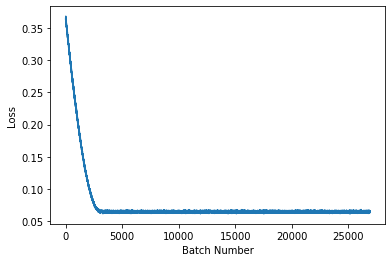

In [0]:
plt.plot(losses)
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()

As the graph shows, the model is able to very quickly learn how to approximate the inputs it was given as a result of decoding outputs, with a fairly consistent loss of about .06

---

Now to measure loss on anomalous data without shuffling it to see if it can detect the increasing abnormality of the sensor data before bearing failure...

training loss:0.0013: 100%|██████████| 6697/6697 [00:54<00:00, 123.67it/s]


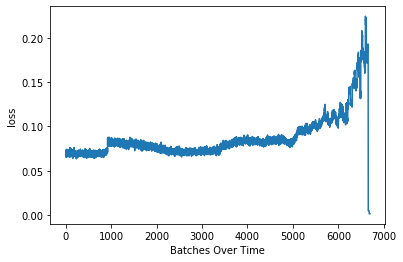

In [0]:
loop = tqdm(total=len(anomalousLoader), position=0)
anomalousLosses = []
for batchNumber, sensorReadings in enumerate(anomalousLoader):
  sensorReadings = sensorReadings.cuda(async=True)

  attemptedReconstruction = testNet(sensorReadings)

  loss = lossFunc(attemptedReconstruction, sensorReadings)

  anomalousLosses.append(loss)

  loop.set_description('anomalous loss:{:.4f}'.format(loss.item()))
  loop.update(1)

loop.close()

plt.plot(anomalousLosses)
plt.xlabel('Batches Over Time')
plt.ylabel('loss')
plt.show()

As the graph demonstrates, this network becomes less effective as the anomalous behavior increases, giving for a clear sign that something is off.

#### Design 2: Create one shrinking and one increasing layer. Each layer will remove or add the number of nodes equal to 1/4 the number of input features. The crux will again have nodes equal to 1/2 the number of input features.

In [0]:
class EncoderDecoder2(nn.Module):
  def __init__(self, inputFeatureCount):
    super(EncoderDecoder2, self).__init__()
    layers = []
    previousLayerSize = inputFeatureCount
    layerSizeChange = inputFeatureCount // 4
    layerSize = inputFeatureCount - layerSizeChange

    layers.append(nn.Linear(previousLayerSize, previousLayerSize))
    layers.append(nn.ReLU())
    
    layers.append(nn.Linear(previousLayerSize, layerSize))
    layers.append(nn.ReLU())

    previousLayerSize = layerSize
    layerSize -= layerSizeChange

    layers.append(nn.Linear(previousLayerSize, layerSize))
    layers.append(nn.ReLU())

    previousLayerSize = layerSize
    layerSize -= layerSizeChange

    layers.append(nn.Linear(previousLayerSize, layerSize))
    layers.append(nn.ReLU())

    previousLayerSize = layerSize
    layerSize += (layerSizeChange * 2)

    layers.append(nn.Linear(previousLayerSize, layerSize))
    layers.append(nn.ReLU())

    previousLayerSize = layerSize
    layerSize += layerSizeChange

    layers.append(nn.Linear(previousLayerSize, layerSize))
    
    self.net = nn.Sequential(*layers)
  
  def forward(self, inputs):
    return self.net(inputs)


###### Train Model On Normal Data

In [0]:
testNet = EncoderDecoder2(len(normalDataSet[0])).cuda()

learningRate = 1e-4

# TODO: try different loss functions, such as MSE
lossFunc = nn.L1Loss()
optimizer = optim.Adam(testNet.parameters(), lr=learningRate)

losses = []
epochs = 2

for epoch in range(epochs):
  loop = tqdm(total=len(normalLoader), position=0)

  for batchNumber, sensorReadings in enumerate(normalLoader):
    sensorReadings = sensorReadings.cuda(async=True)
    optimizer.zero_grad()

    attemptedReconstruction = testNet(sensorReadings)

    loss = lossFunc(attemptedReconstruction, sensorReadings)

    losses.append(loss)

    loop.set_description('normal loss:{:.4f}'.format(loss.item()))
    loop.update(1)

    loss.backward()
    optimizer.step()

  loop.close()

normal loss:0.0650: 100%|██████████| 13456/13456 [01:57<00:00, 114.12it/s]


Plot training loss over time to see if the network can learn to re-create the sensor readings from fairly homogenous data

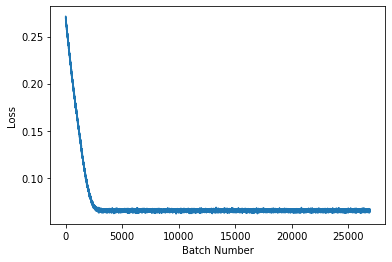

In [0]:
plt.plot(losses)
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()

As the graph shows, the model is able to very quickly learn how to approximate the inputs it was given as a result of decoding outputs, with a fairly consistent loss of about .04

---

Now to measure loss on anomalous data without shuffling it to see if it can detect the increasing abnormality of the sensor data before bearing failure...

anomalous loss:0.0014: 100%|██████████| 6697/6697 [00:40<00:00, 163.41it/s]


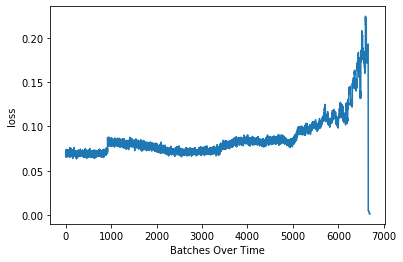

In [0]:
loop = tqdm(total=len(anomalousLoader), position=0)
anomalousLosses = []
for batchNumber, sensorReadings in enumerate(anomalousLoader):
  sensorReadings = sensorReadings.cuda(async=True)

  attemptedReconstruction = testNet(sensorReadings)

  loss = lossFunc(attemptedReconstruction, sensorReadings)

  anomalousLosses.append(loss)

  loop.set_description('anomalous loss:{:.4f}'.format(loss.item()))
  loop.update(1)

loop.close()

plt.plot(anomalousLosses)
plt.xlabel('Batches Over Time')
plt.ylabel('loss')
plt.show()

As the graph demonstrates, this network becomes less effective as the anomalous behavior increases, giving for a clear sign that something is off.

#### Design 3: Create convolutional layers that shrink and then expand the number of data points back to the original size

##### Create Modified Data Loader

In [0]:
#The data loader needs to return the data in chunks
#The rows of data are 1 second snapshots, so the chunk size corresponds to the number of seconds for the model to consider at once
class bearingChunkDataset(Dataset):
  def __init__(self, tsvFileDirectory, chunkSize=1):
    frame = pd.read_csv(tsvFileDirectory, sep='\t')

    numRows, numCols = frame.shape

    leftoverRowCount = numRows % chunkSize

    if leftoverRowCount > 0:
      paddingLength = chunkSize - leftoverRowCount
    
      padding = [[0] * numCols] * paddingLength

      frame = frame.append(padding)

      numRows, numCols = frame.shape

    numChunks = numRows // chunkSize

    data = torch.tensor(frame.values, dtype=torch.float)

    self.data = torch.reshape(data, (numChunks, chunkSize, numCols))

    # Comment the 2 lines above and uncomment the 2 lines below to transpose the data

    # data = torch.transpose(torch.tensor(frame.values, dtype=torch.float), 0, 1)

    # self.data = torch.reshape(data, (numChunks, numCols, chunkSize))

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    return self.data[index]

normalDataSet = bearingChunkDataset('2nd_test/normalBehavior.tsv', chunkSize=10)
anomalousDataSet = bearingChunkDataset('2nd_test/anomalousBehavior.tsv', chunkSize=10)

normalChunkLoader = DataLoader(normalDataSet, batch_size=1000, num_workers=4, pin_memory=True, shuffle=True)
anomalousChunkLoader = DataLoader(anomalousDataSet, batch_size = 1000, num_workers=4, pin_memory=True, shuffle=False)

##### Create Convolutional Network

In [0]:
class EncoderDecoder3(nn.Module):
  def __init__(self, chunkSize, features):
    super(EncoderDecoder3, self).__init__()

    # TODO: Create 2 convolutions to halve the series and then upscale them back up.
    self.net = nn.Sequential(
        nn.Conv2d(1, 1, (chunkSize // 2, features)),
        nn.ReLU(),

    )

### Concept 2: Simple Feed-Forward Network

This is the simplest model that will be tested for use in failure detection. It will simply be a feed-forward multi-layer perceptron which takes in one row of data at a time and be trained to output whether or not the behavior is anomalous. This will require large chunks of data to be labelled as anomalous or non-anomalous, then shuffled and fed through one row at a time into the network.

In [0]:
#TODO: Create labels on files with !sed -e 's/$/,<0 or 1 depending on anomalous status>/' -i <filename>, then cat together to create one file for conventional testing

## Failure Prediction

### Concept 1: LSTM-based Recurrent Neural Net

This model will be given chunks of data measurements, and then at the end output a probability that the device is going to fail. This will require the data to be sliced up into chunks of anomalous and non-anomalous behavior by hand, or possibly automatically if the anomaly detection model(s) above work very well after they are developed.

### Concept 2: GRU-based Recurrent Neural Net

Same as the previous concept, except using GRU units in place of LSTM units.

### Concept 3: Convolutional Neural Net

The idea behind this is to take a chunk of the sensor readings all at once and feed them through convolutional layers in order to recognize patterns indicative of failure. This model is last because it seems not as natural of a fit for the problem as the other models.